In [1]:
pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d olistbr/brazilian-ecommerce

 66% 28.0M/42.6M [00:00<00:00, 150MB/s] 
100% 42.6M/42.6M [00:00<00:00, 119MB/s]


In [6]:
! unzip /content/brazilian-ecommerce.zip

Archive:  /content/brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import datetime
from scipy import sparse
import scipy.sparse
from sklearn.cluster import KMeans

In [293]:
customersDF = pd.read_csv("/content/olist_customers_dataset.csv")
sellersDF = pd.read_csv("/content/olist_sellers_dataset.csv")
order_reviewsDF = pd.read_csv("/content/olist_order_reviews_dataset.csv") 
ordersDF = pd.read_csv("/content/olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date','order_delivered_carrier_date'])
productsDF = pd.read_csv("/content/olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("/content/product_category_name_translation.csv") 
order_itemsDF = pd.read_csv("/content/olist_order_items_dataset.csv",parse_dates=['shipping_limit_date'])
geolocationDF = pd.read_csv("/content/olist_geolocation_dataset.csv")
order_paymentsDF = pd.read_csv("/content/olist_order_payments_dataset.csv") 

### Order Reviews DataSet

In [294]:
## replace missing data with an appropriate label in order reviews data
order_reviewsDF["review_comment_title"] = order_reviewsDF["review_comment_title"].replace(np.nan, "no title")
order_reviewsDF["review_comment_message"] = order_reviewsDF["review_comment_message"].replace(np.nan,"no comment given")

In [295]:
## converting datetime columns to the right format
order_reviewsDF["review_creation_date"] = pd.to_datetime(order_reviewsDF["review_creation_date"])
order_reviewsDF["review_answer_timestamp"] = pd.to_datetime(order_reviewsDF["review_answer_timestamp"])

In [296]:
## changing all the the text to lowercase letter
order_reviewsDF["review_comment_title"] = order_reviewsDF["review_comment_title"].str.lower()
order_reviewsDF["review_comment_message"] = order_reviewsDF["review_comment_message"].str.lower()

In [297]:
order_reviewsDF.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no title,no comment given,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no title,no comment given,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no title,no comment given,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,no title,recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,no title,parabéns lojas lannister adorei comprar pela i...,2018-03-01,2018-03-02 10:26:53


### Orders DataSet

In [298]:
## dropping Nan values and cancelled orders
ordersDF.dropna(inplace = True)
ordersDF.drop(ordersDF[ordersDF.order_status == "canceled"].index, inplace = True)
ordersDF.reset_index(drop = True, inplace = True)

### Products DataSet

In [299]:
## removing products with no description
productsDF.dropna(inplace = True)
productsDF.reset_index(drop = True, inplace = True)

In [300]:
## getting the translation of the product category name using the translationDF
product_category_name_translation = product_category_name_translation.set_index("product_category_name")
product_category_name_translation = product_category_name_translation.to_dict('dict')
productsDF["product_category_name"] = productsDF["product_category_name"].replace(product_category_name_translation["product_category_name_english"])

In [301]:
productsDF.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Geolocation DataSet

In [302]:
geolocationDF.shape

(1000163, 5)

In [303]:
geolocationDF.geolocation_zip_code_prefix.nunique()

19015

In [304]:
## location data seems to have many duplicates with very little lat and lng variations between each. 
## Keeping only the first of each zip code will help avoid merge issues later on
geolocationDF.drop_duplicates(subset = ['geolocation_zip_code_prefix'], keep = 'first', inplace = True)

### Creating dataframes containing seller and customer information which will help in creating the data in the format we need to build a recommendation engine

#### To properly analyze customer ratings and seller influences we combine dataframes related to their respective content.

In [305]:
customer_purchases = reduce(lambda left,right: pd.merge(left,right, how = 'inner', on="order_id"), [ordersDF, order_itemsDF, order_reviewsDF])

## drop duplicate rows based on all columns except the one's related to the reviews
customer_purchases.drop_duplicates(keep = 'first',subset=customer_purchases.columns.difference(['review_id', 'review_answer_timestamp', 'review_creation_date']),inplace=True)

## dropping columns related to delivery and order status
customer_purchases.drop(['order_approved_at', 'order_delivered_carrier_date', 'order_status'], 1, inplace=True)

## adding customers geolocation information to customer_purchases df and dropping columns that are not required
customer_info = pd.merge(pd.merge(customer_purchases, customersDF, on = 'customer_id'), geolocationDF,left_on ='customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').drop(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], 1).reset_index(drop=True)

# merging product info to get the product_category name from productsDF
customer_info = customer_info.merge(productsDF, on = 'product_id')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [306]:
customer_info.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,...,geolocation_lat,geolocation_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,...,-23.574809,-46.587471,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,2017-11-13,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,...,-27.536913,-48.509018,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,...,-23.565578,-46.534603,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,...,-23.543295,-46.630743,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,2018-03-22 17:23:21,2018-03-25 17:22:41,2018-04-04,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,...,-23.574809,-46.587471,bed_bath_table,55.0,273.0,1.0,1050.0,38.0,10.0,38.0


In [307]:
## merge dataframes together that give us seller information
seller_info = pd.merge(pd.merge(pd.merge(pd.merge(order_itemsDF,sellersDF, on = 'seller_id'),productsDF, on = 'product_id'),order_reviewsDF, on = 'order_id'),geolocationDF, how = 'inner', left_on ='seller_zip_code_prefix',right_on = 'geolocation_zip_code_prefix')

# drop redundant and unnecessary columns
seller_info.drop(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state', 'freight_value'], 1, inplace=True)
seller_info.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [308]:
seller_info.drop_duplicates(keep = "first", subset=seller_info.columns.difference(['review_id', 'review_answer_timestamp', 'review_creation_date']),inplace=True)

In [309]:
seller_info.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,seller_zip_code_prefix,seller_city,seller_state,product_category_name,...,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_lat,geolocation_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,97ca439bc427b48bc1cd7177abe71365,5,no title,"perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,-22.498183,-44.123614
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,b11cba360bbe71410c291b764753d37f,5,no title,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-07-17 12:50:07,-22.498183,-44.123614
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05,2018-06-06 21:41:12,-22.498183,-44.123614
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,8304ff37d8b16b57086fa283fe0c44f8,5,no title,no comment given,2017-08-10,2017-08-13 03:35:17,-22.498183,-44.123614
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,426f43a82185969503fb3c86241a9535,5,no title,no comment given,2017-08-25,2017-08-28 00:51:18,-22.498183,-44.123614


In [310]:
# only looking at the common orders in the two data frames
sellers_data = seller_info[seller_info.order_id.isin(customer_info.order_id)]
customers_data = customer_info[customer_info.order_id.isin(seller_info.order_id)]

In [311]:
## dropping entries where product category name is NULL
sellers_data = sellers_data.dropna(subset = ['product_category_name']).reset_index(drop=True)
customers_data = customers_data.dropna(subset=['product_category_name']).reset_index(drop=True)

In [312]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107668 entries, 0 to 107667
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       107668 non-null  object        
 1   customer_id                    107668 non-null  object        
 2   order_purchase_timestamp       107668 non-null  datetime64[ns]
 3   order_delivered_customer_date  107668 non-null  datetime64[ns]
 4   order_estimated_delivery_date  107668 non-null  datetime64[ns]
 5   order_item_id                  107668 non-null  int64         
 6   product_id                     107668 non-null  object        
 7   seller_id                      107668 non-null  object        
 8   shipping_limit_date            107668 non-null  datetime64[ns]
 9   price                          107668 non-null  float64       
 10  freight_value                  107668 non-null  float64       
 11  

In [313]:
sellers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107664 entries, 0 to 107663
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    107664 non-null  object        
 1   order_item_id               107664 non-null  int64         
 2   product_id                  107664 non-null  object        
 3   seller_id                   107664 non-null  object        
 4   shipping_limit_date         107664 non-null  datetime64[ns]
 5   price                       107664 non-null  float64       
 6   seller_zip_code_prefix      107664 non-null  int64         
 7   seller_city                 107664 non-null  object        
 8   seller_state                107664 non-null  object        
 9   product_category_name       107664 non-null  object        
 10  product_name_lenght         107664 non-null  float64       
 11  product_description_lenght  107664 non-

### now using the above two dataframes we create a master_df which we will be the base data we will use for building the recommendation system and in creating user features using clustering techniques

In [314]:
master_df = customers_data.merge(sellers_data[['order_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']], on ='order_id', ).drop(['order_delivered_customer_date', 
                                                          'order_estimated_delivery_date', 'shipping_limit_date',
                                                         'freight_value', 'review_comment_title', 'review_creation_date', 
                                                          'review_answer_timestamp', 'geolocation_lat', 'geolocation_lng',
                                                         'product_name_lenght', 'product_description_lenght', 'product_length_cm',
                                                          'product_height_cm', 'product_width_cm', 'review_id'], axis=1)

In [315]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151090 entries, 0 to 151089
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  151090 non-null  object        
 1   customer_id               151090 non-null  object        
 2   order_purchase_timestamp  151090 non-null  datetime64[ns]
 3   order_item_id             151090 non-null  int64         
 4   product_id                151090 non-null  object        
 5   seller_id                 151090 non-null  object        
 6   price                     151090 non-null  float64       
 7   review_score              151090 non-null  int64         
 8   review_comment_message    151090 non-null  object        
 9   customer_unique_id        151090 non-null  object        
 10  customer_zip_code_prefix  151090 non-null  int64         
 11  customer_city             151090 non-null  object        
 12  cu

### We will extract information about each product and user from the master_df.

In [316]:
user_item = master_df[['customer_id', 'customer_unique_id', 'product_id', 'review_score', 'order_purchase_timestamp']]
user_features = master_df[['customer_unique_id', 'customer_city', 'customer_state']]
item_features = master_df[['customer_unique_id','product_id', 'customer_id', 'product_category_name', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price', 'order_id', 'order_item_id']]

In [317]:
item_features = item_features.drop_duplicates(['customer_id','order_id', 'order_item_id']).reset_index(drop=True)

### Now we create some aggregated columns to improve upon the product features

In [318]:
# to avoid counting a review comment labeled 'no comment given', we will convert them back to NAN
item_features['review_comment_message'] = item_features.review_comment_message.replace('no comment given', np.nan)

# create average review score column 
item_features['avg_product_score'] = item_features['review_score'].groupby(item_features['product_id']).transform('mean')

# create average review score column 
item_features['avg_seller_score'] = item_features['review_score'].groupby(item_features['seller_id']).transform('mean')

# create the number of comments column
item_features['num_comments'] = item_features['review_comment_message'].groupby(item_features['product_id']).transform('count')

# create the number of reviews column
item_features['num_reviews'] = item_features['review_score'].groupby(item_features['product_id']).transform('count')

# create average price column
item_features['avg_price'] = item_features[['price']].groupby(item_features['product_id']).transform('mean')

# Create product_count column for the rating
item_features['product_count'] = item_features['product_id'].groupby(item_features['customer_unique_id']).transform('count')

### ****************************** clustering code starts *****************************************************************

### For our model to perform well we look for common features among users and try to cluster them.

In [319]:
master_df = master_df.drop_duplicates(['order_id', 'order_item_id']).dropna().reset_index(drop=True)

In [320]:
master_df.product_category_name.value_counts()[:20]

bed_bath_table              10803
health_beauty                9375
sports_leisure               8359
furniture_decor              8057
computers_accessories        7586
housewares                   6738
watches_gifts                5791
telephony                    4374
garden_tools                 4228
auto                         4089
toys                         3964
cool_stuff                   3643
perfumery                    3314
baby                         2949
electronics                  2617
stationery                   2438
fashion_bags_accessories     1968
pet_shop                     1894
office_furniture             1648
consoles_games               1075
Name: product_category_name, dtype: int64

In [321]:
item_features_new = master_df[['customer_unique_id', 'customer_id','product_id', 'order_id', 'product_category_name', 'order_item_id', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price']]

In [322]:
# Create product_count column for the rating
item_features_new['product_category_count'] = item_features_new[['product_category_name', 'customer_unique_id', 'order_item_id']]\
                                                            .groupby(['customer_unique_id', 'product_category_name'])['order_item_id']\
                                                            .transform('count')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [323]:
## creating user product interactions
user_to_product_category = item_features_new[['product_category_name', 'customer_unique_id', 'product_category_count']]\
                                        .sort_values(by='customer_unique_id')\
                                        .reset_index(drop=True)
user_to_product_category['product_count'] = 1
user_to_product_category = user_to_product_category.drop(['product_category_count'], axis=1)

In [324]:
## creating a list of users and items
user_list = np.sort(user_to_product_category["customer_unique_id"].unique())
item_list =  user_to_product_category["product_category_name"].unique()

In [325]:
## defining a funtion to create mappings for user id and item id
def id_mappings(user_list, item_list):
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        

    return user_to_index_mapping, index_to_user_mapping,item_to_index_mapping, index_to_item_mapping

In [326]:
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [327]:
user_to_index_mapping, index_to_user_mapping,item_to_index_mapping, index_to_item_mapping = id_mappings(user_list, item_list)

In [328]:
user_to_product_category_interaction = get_interaction_matrix(user_to_product_category, "customer_unique_id", 
                                                           "product_category_name", "product_count", 
                                                           user_to_index_mapping, item_to_index_mapping)

In [329]:
product_category_to_user_interaction = get_interaction_matrix(user_to_product_category, "product_category_name", 
                                                             "customer_unique_id", "product_count",
                                                             item_to_index_mapping, user_to_index_mapping)

### now we use k means to perform clustering

In [330]:
data1 = pd.DataFrame(user_to_product_category_interaction.todense())
x_cols = data1.values
k_values = range(2, 20)
inertias = []

for k in k_values:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters = k, random_state=42)
    # fit model to samples
    kmeans.fit(x_cols)
    # append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)

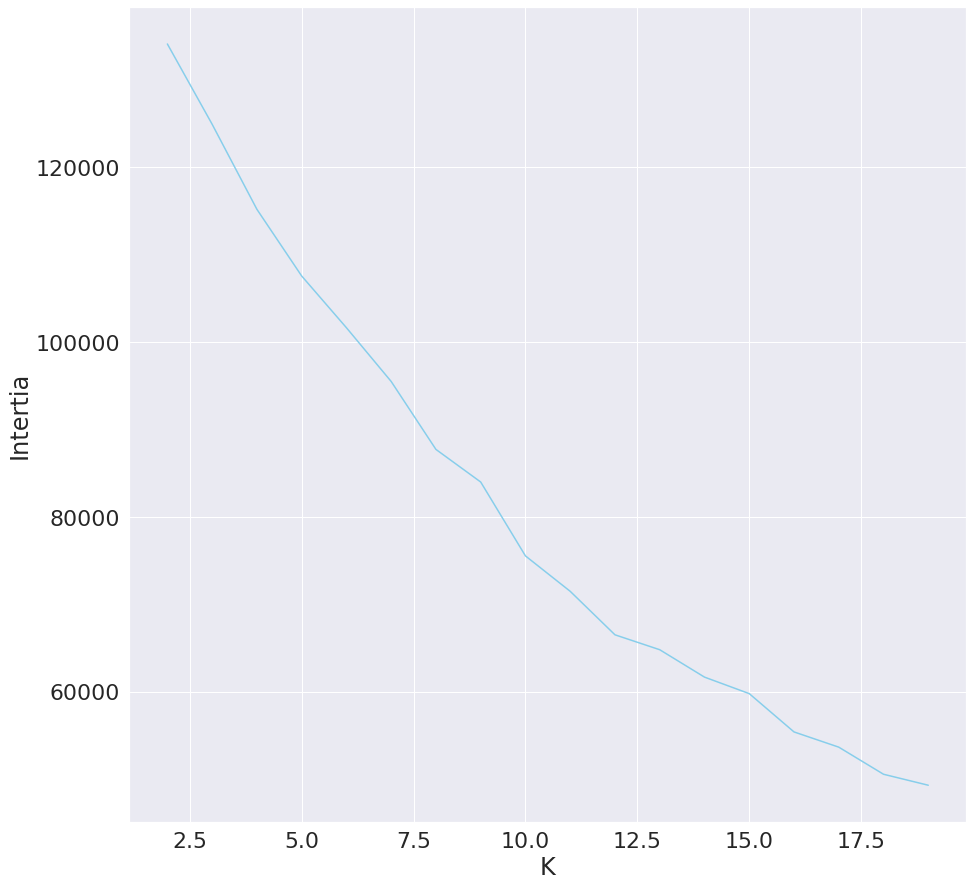

In [331]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))
sns.set(font_scale = 2)
sns.lineplot(x=k_values,y=inertias,color="skyblue", ax=axs)
axs.set_xlabel("K")
axs.set_ylabel("Intertia")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


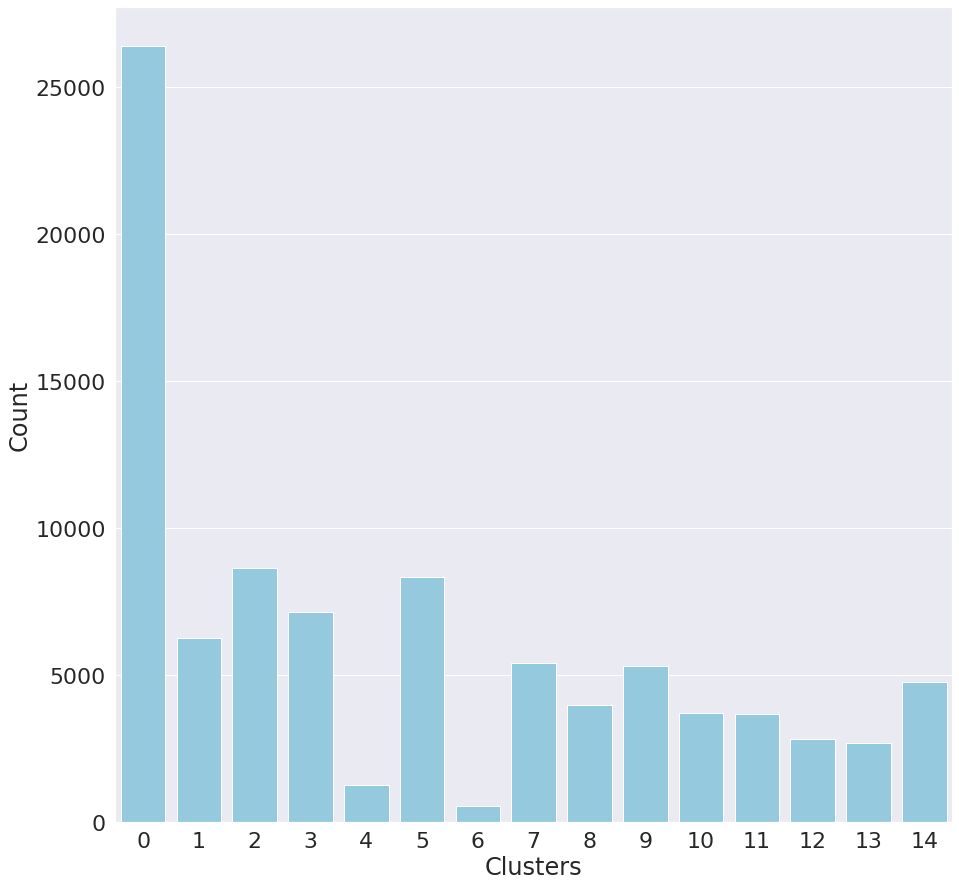

In [332]:
# create a KMeans instance with k clusters
model = KMeans(n_clusters = 15, random_state=42)
# fit model to samples
model.fit(x_cols)
labels = model.predict(x_cols)
clusters, npoints = np.unique(labels, return_counts=True)
fig, axs = plt.subplots(1, 1, figsize=(15,15))
sns.set(font_scale = 2)
sns.barplot(clusters,npoints,color="skyblue", ax=axs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Count")
plt.show()

In [333]:
labels = pd.DataFrame({'cluster_id': labels})
data1.index.name = 'customer_unique_id'
data1 = data1.reset_index()

In [334]:
df = pd.concat([data1.customer_unique_id,labels], axis=1, sort=False)

In [335]:
df["customer_unique_id"] = index_to_user_mapping.values()

In [336]:
df.head()

,customer_unique_id,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,8
4,0004aac84e0df4da2b147fca70cf8255,8


In [337]:
item_features_clustered = item_features_new.merge(df, on = 'customer_unique_id')

### ************************************** end of clustering code ******************************************************

### Transform columns in items_features df to improve the performance of  distance based algorithms

In [338]:
item_features['log_avg_price'] = np.log1p(item_features['avg_price'])
item_features['log_num_reviews'] = np.log1p(item_features['num_reviews'])
item_features['log_num_comments'] = np.log1p(item_features['num_comments'])
# use cut to group the same number of reviews in each section
item_features['num_reviews_binned'] = pd.cut(item_features['log_num_reviews'], 7, duplicates = 'drop')
item_features['num_comments_binned'] = pd.cut(item_features['log_num_comments'], 6, duplicates = 'drop')

item_features['avg_product_reviews_binned'] = pd.cut(item_features['avg_product_score'], 4, duplicates = 'drop')
item_features['avg_seller_reviews_binned'] = pd.cut(item_features['avg_seller_score'], 4, duplicates = 'drop')

item_features['avg_price_binned'] = pd.qcut(item_features['avg_price'], 4, duplicates = 'drop')
item_features = item_features.sort_values('customer_unique_id').reset_index(drop=True)

cols = ['num_reviews_binned', 'num_comments_binned','avg_product_reviews_binned','avg_seller_reviews_binned', 'avg_price_binned']
for col in cols:
    item_features[col] = item_features[col].astype(str)

In [339]:
item_features.head()

,customer_unique_id,product_id,customer_id,product_category_name,seller_id,review_score,review_comment_message,seller_city,seller_state,price,...,avg_price,product_count,log_avg_price,log_num_reviews,log_num_comments,num_reviews_binned,num_comments_binned,avg_product_reviews_binned,avg_seller_reviews_binned,avg_price_binned
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,fadbb3709178fc513abc1b2670aa1ad2,bed_bath_table,da8622b14eb17ae2831f4ac5b9dab84a,5,"adorei a cortina, ficou linda na minha sala, e...",piracicaba,SP,129.90,...,109.382759,1,4.703954,3.401197,2.397895,"(3.073, 3.866]","(1.813, 2.719]","(4.0, 5.0]","(4.0, 5.0]","(74.9, 135.0]"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,4cb282e167ae9234755102258dd52ee8,health_beauty,138dbe45fc62f1e244378131a6801526,4,NaN,sao paulo,SP,18.90,...,19.042857,1,2.997873,2.079442,0.693147,"(1.486, 2.28]","(-0.00544, 0.906]","(4.0, 5.0]","(3.0, 4.0]","(0.849, 39.9]"
2,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,9b3932a6253894a02c1df9d19004239f,stationery,3d871de0142ce09b7081e2b9d1733cb1,3,NaN,campo limpo paulista,SP,69.00,...,73.000000,1,4.304065,1.791759,1.098612,"(1.486, 2.28]","(0.906, 1.813]","(4.0, 5.0]","(4.0, 5.0]","(39.9, 74.9]"
3,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,914991f0c02ef0843c0e7010c819d642,telephony,ef506c96320abeedfb894c34db06f478,4,bom vendedor,sao paulo,SP,25.99,...,27.990000,1,3.366951,1.386294,1.098612,"(0.688, 1.486]","(0.906, 1.813]","(4.0, 5.0]","(3.0, 4.0]","(0.849, 39.9]"
4,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,47227568b10f5f58a524a75507e6992c,telephony,70a12e78e608ac31179aea7f8422044b,5,NaN,jacarei,SP,180.00,...,180.000000,1,5.198497,0.693147,0.000000,"(0.688, 1.486]","(-0.00544, 0.906]","(4.0, 5.0]","(3.0, 4.0]","(135.0, 6735.0]"


### adding the clustered groupings to user features

In [340]:
user_features = pd.merge(user_features, item_features_clustered[['customer_unique_id', 'cluster_id']], on = 'customer_unique_id', how='left').drop('customer_city', axis=1)

In [341]:
## creating the user and item list
users =  np.sort(user_item["customer_unique_id"].unique())
items = item_features["product_id"].unique()

### defining functions to get the item feature list and user feature list

In [342]:
def get_item_feature_list(df, product_category_col, seller_col, seller_rating_col, product_rating_col, 
                          num_comments, num_reviews, avg_price, seller_city, seller_state):
    
    categories = df[product_category_col]
    sellers = df[seller_col]
    seller_ratings = df[seller_rating_col]
    product_ratings = df[product_rating_col]
    num_product_comments = df[num_comments]
    num_product_reviews = df[num_reviews]
    avg_product_price = df[avg_price]
    seller_city = df[seller_city]
    seller_state = df[seller_state]
    
    return pd.concat([categories, sellers, seller_ratings, product_ratings, num_product_comments, 
                      num_product_reviews, avg_product_price, seller_city, seller_state], ignore_index = True).unique()

def get_user_feature_list(df, cluster_id, customer_state):
    
    customer_state = df[customer_state]
    cluster_id = df[cluster_id]
    
    return pd.concat([cluster_id, customer_state], ignore_index = True).unique()

In [343]:
item_features_list = get_item_feature_list(item_features, "product_category_name", "seller_id", "avg_seller_reviews_binned",
                                           "avg_product_reviews_binned", "num_comments_binned", "num_reviews_binned", 
                                           "avg_price_binned", "seller_city", "seller_state")
user_features_list = get_user_feature_list(user_features, "cluster_id", "customer_state")

### defining the id mappings function below to convert string ID's into numbers for Product, customer and features.

In [344]:
def id_mappings2(user_list, item_list, item_feature_list, user_feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    item_feature_to_index_mapping = {}
    index_to_item_feature_mapping = {}
    for item_feature_index, item_feature_id in enumerate(item_feature_list):
        item_feature_to_index_mapping[item_feature_id] = item_feature_index
        index_to_item_feature_mapping[item_feature_index] = item_feature_id

    user_feature_to_index_mapping = {}
    index_to_user_feature_mapping = {}
    for user_feature_index, user_feature_id in enumerate(user_feature_list):
        user_feature_to_index_mapping[user_feature_id] = user_feature_index
        index_to_user_feature_mapping[user_feature_index] = user_feature_id
        
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           item_feature_to_index_mapping, index_to_item_feature_mapping, \
           user_feature_to_index_mapping, index_to_user_feature_mapping

In [345]:
# generate mapping
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           item_feature_to_index_mapping, index_to_item_feature_mapping, \
           user_feature_to_index_mapping, index_to_user_feature_mapping = id_mappings2(users, items, item_features_list, 
                                                                            user_features_list)

In [346]:
product_to_feature = item_features[['product_id', 'product_category_name', 'seller_id', 'num_reviews_binned', 
                                    'num_comments_binned', 'avg_product_reviews_binned', 'avg_seller_reviews_binned',
                                    'avg_price_binned', 'seller_city', 'seller_state']]
product_to_feature = product_to_feature.drop_duplicates('product_id').reset_index(drop=True)

In [347]:
user_to_product_rating = item_features[['customer_unique_id', 'product_id', 'product_count']]
user_to_product_rating = user_to_product_rating.sort_values(by='customer_unique_id').reset_index(drop=True)

## Model Development

In [224]:
pip install lightfm

In [348]:
import time
from lightfm import LightFM
from lightfm.evaluation import auc_score
import random
from scipy import sparse
from prettytable import PrettyTable
import itertools
import numpy as np

### Train Test - Split

In [349]:
np.random.seed(2)

#randomly splitting the dataset into train and test
rows = np.random.binomial(1, .8, size=len(user_to_product_rating)).astype('bool')

#Spliting the dataset and getting train and test data
user_to_product_rating_train = user_to_product_rating[rows].reset_index(drop = True)
user_to_product_rating_test = user_to_product_rating[~rows].reset_index(drop = True)

### Creating Product - Feature df

#### Product df

In [284]:
#Transposing the dataset and setting product id as index
df = product_to_feature.set_index('product_id').T.reset_index(drop = True)

In [285]:
cols = list(df.columns)
res = []
for i in cols:
  for j in range(len(product_to_feature.columns) - 1):
    res.append(i)

In [286]:
#Creating empty dataframe having product_id as index
features = pd.DataFrame(index = res)
features.index.name = 'product_id'

# Reseting index
features = features.reset_index()

#Making an empty column that will store the feature for each product id
features['feature'] = ""

#### Feature df

In [287]:
# Creating a list of features that will be used as feature column in the df
featuress = []
for i in cols:
  for j in range(len(product_to_feature.columns) - 1):
    featuress.append(df[i][j])

In [350]:
# Assigning the feature column to list that we created above
features['feature'] = featuress
product_to_feature = features

#Creating a new column feature count and setting it to 1 for sparse matrix
product_to_feature['feature_count'] = 1

In [351]:
product_to_feature.head(10)

,product_id,feature,feature_count
0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1
1,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,1
2,372645c7439f9661fbbacfd129aa92ec,"(3.073, 3.866]",1
3,372645c7439f9661fbbacfd129aa92ec,"(1.813, 2.719]",1
4,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
5,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
6,372645c7439f9661fbbacfd129aa92ec,"(74.9, 135.0]",1
7,372645c7439f9661fbbacfd129aa92ec,piracicaba,1
8,372645c7439f9661fbbacfd129aa92ec,SP,1
9,5099f7000472b634fea8304448d20825,health_beauty,1


### User to Feature Interaction

In [352]:
user_to_feature = user_features.drop_duplicates('customer_unique_id').reset_index(drop = True)

In [353]:
# Transposing product_to_feature for getting features for individual customers
df = user_to_feature.set_index('customer_unique_id').T.reset_index(drop = True)

In [354]:
df.head()

customer_unique_id,7c396fd4830fd04220f754e42b4e5bff,e781fdcc107d13d865fc7698711cc572,3a51803cc0d012c3b5dc8b7528cb05f7,ef0996a1a279c26e7ecbd737be23d235,8a4002923e801e3120a11070fd31c9e2,0cad1c6c08ef74b3ae7818514c158258,eb5c27c09badfe9c053416ca5c3c7c35,6eff1cd9cc7f4dde6e1cbb679e219a50,cc3f5d537772957f90b7f15f1fb70316,87c9eb971f4cfcbefa08cb27b21bc9a7,...,17cb19c8526583b203e7a3a6c828d3aa,7ce47ba6982b3ce9bee72ab948481f9e,79e8da40d2295512051a82eda0663058,f9ccc64481a04c1a9886994895b97f03,f5138d94d7e1085c5219408f32b62529,8b8c8f067a3faaf116211277147a88de,1ef6a1d949703afd7a74347aed3b0503,ebc6df639d125e446f07c0e9b1e47b90,ed81a42bec90c87578108d2e4c742d20,a49e8e11e850592fe685ae3c64b40eca
0,SP,SC,SP,SP,SP,SP,SP,RJ,SP,SP,...,PE,RS,AP,PB,SP,MG,TO,MG,BA,PR
1,13,7,7,7,2,2,2,2,2,2,...,5,10,0,10,7,3,8,0,10,0


In [355]:
cols = list(df.columns)
res = []
for i in cols:
  for j in range(len(user_to_feature.columns) - 1):
    res.append(i)

In [356]:
# Creating empty dataframe that will have the index as product_id 
user_feature = pd.DataFrame(index = res)
user_feature.index.name = 'customer_unique_id'

# Reseting index, so that product id becomes columns
user_feature = user_feature.reset_index()

# Creating Emplty dataframe for user feature
user_feature['feature'] = ""

In [357]:
# Creating list of features items that will be used as column
feature_items = []
for i in cols:
  for j in range(len(user_to_feature.columns)-1):
    feature_items.append(df[i][j])

In [358]:
user_feature['feature'] = feature_items
user_to_feature = user_feature
user_to_feature['feature_count'] = 1

In [359]:
# 10 total features for each product
product_to_feature.head(10)

,product_id,feature,feature_count
0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1
1,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,1
2,372645c7439f9661fbbacfd129aa92ec,"(3.073, 3.866]",1
3,372645c7439f9661fbbacfd129aa92ec,"(1.813, 2.719]",1
4,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
5,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
6,372645c7439f9661fbbacfd129aa92ec,"(74.9, 135.0]",1
7,372645c7439f9661fbbacfd129aa92ec,piracicaba,1
8,372645c7439f9661fbbacfd129aa92ec,SP,1
9,5099f7000472b634fea8304448d20825,health_beauty,1


In [360]:
# two features for each user
user_to_feature.head(2)

,customer_unique_id,feature,feature_count
0,7c396fd4830fd04220f754e42b4e5bff,SP,1
1,7c396fd4830fd04220f754e42b4e5bff,13,1


In [361]:
# count for each user for the products they purchased
user_to_product_rating_train.head()

,customer_unique_id,product_id,product_count
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,1
2,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,1
3,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,1
4,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,1


In [362]:
user_to_product_rating_test.head()

,customer_unique_id,product_id,product_count
0,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,1
1,000d460961d6dbfa3ec6c9f5805769e1,53075a78fc601d6eb47e8ad2d142b7a8,1
2,00172711b30d52eea8b313a7f2cced02,8f71fe1e1b5bbb6773e7276b5c37ef65,1
3,001926cef41060fae572e2e7b30bd2a4,5d66715cc928aadd0074f61332698593,2
4,0019e8c501c85848ac0966d45226fa1d,1dfb36d969d347f56f43590ec42c7b8c,1


In [367]:
#Created a function that will return the sparse matrix
def generate_matrix(df, df_row, df_col, df_value, row_index, col_index):
    
    row = df[df_row].apply(lambda x: row_index[x]).values
    col = df[df_col].apply(lambda x: col_index[x]).values
    value = df[df_value].values

    return sparse.coo_matrix((value, (row, col)), shape = (len(row_index), len(col_index)))

In [368]:
# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = generate_matrix(user_to_product_rating_train, "customer_unique_id", "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = generate_matrix(user_to_product_rating_test, "customer_unique_id", "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = generate_matrix(product_to_feature, "product_id", "feature",  "feature_count", item_to_index_mapping, item_feature_to_index_mapping)

user_to_feature_interaction = generate_matrix(user_to_feature, "customer_unique_id", "feature", "feature_count", user_to_index_mapping, user_feature_to_index_mapping)

## Model with Collaborative Filtering & Product content

In [371]:
# Initializing LightFM Model
model_with_features = LightFM(loss = "warp")

model_with_features.fit(user_to_product_interaction_train, user_features = None, item_features = product_to_feature_interaction, sample_weight = None, epochs = 1,  num_threads = 4, verbose = False)

auc_with_features = auc_score(model = model_with_features, test_interactions = user_to_product_interaction_test, train_interactions = user_to_product_interaction_train, user_features = None, item_features = product_to_feature_interaction, num_threads = 4, check_intersections = False)

print("Average AUC of model having item-feature interaction = ", round(auc_with_features.mean(), 4))

Average AUC of model having item-feature interaction =  0.7869


## Model with hybrid collaborative filtering and content based including user features

In [372]:
model_with_features_and_users = LightFM(loss = "warp")

# Fitting the model with hybrid collaborative filtering and content based (product & features)
model_with_features_and_users.fit(user_to_product_interaction_train, user_features = user_to_feature_interaction, item_features = product_to_feature_interaction, sample_weight = None, epochs = 1, num_threads = 4,verbose = False)

# Testing the model and calculating the AUC Score
auc_with_features = auc_score(model = model_with_features_and_users, test_interactions = user_to_product_interaction_test, train_interactions = user_to_product_interaction_train, user_features = user_to_feature_interaction, item_features = product_to_feature_interaction, num_threads = 4, check_intersections = False)

print("Average AUC of model having item-feature & user-feature interaction = ",round(auc_with_features.mean(), 4))

Average AUC of model having item-feature & user-feature interaction =  0.9594


### Combining train and test data for individual user recommendations

In [373]:
def combined_train_test(train, test):

    #Creating train dictionary
    train_dict = {}
    for row, col, train_value in zip(train.row, train.col, train.data):
        train_dict[(row, col)] = train_value
        
    #Adding the test data
    for row, col, test_value in zip(test.row, test.col, test.data):
        train_dict[(row, col)] = max(test_value, train_dict.get((row, col), 0))
        
    #Aggregating with train data    
    row_temp = []
    col_temp = []
    data_temp = []
    for row, col in train_dict:
        row_temp.append(row)
        col_temp.append(col)
        data_temp.append(train_dict[(row, col)])

    #Converting dictonary to np array for creating sparse matrix    
    row_element = np.array(row_temp)
    col_element = np.array(col_temp)
    data_element = np.array(data_temp)
    
    return sparse.coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

In [374]:
# Creating user-product interaction matrix
user_to_product_interaction = combined_train_test(user_to_product_interaction_train, user_to_product_interaction_test)

In [376]:
# Making the final model with combined data
initial_model_1 = LightFM(loss = "warp")

# Fitting the commbined data with collaborative filtering output
initial_model_1.fit(user_to_product_interaction, user_features = None, item_features = product_to_feature_interaction, sample_weight = None, epochs = 1, num_threads = 4, verbose = False)

### Fitting model with user-features

In [377]:
# Making the final model with combined data
initial_model_2 = LightFM(loss = "warp")

# Fitting the commbined data with collaborative filtering output
initial_model_2.fit(user_to_product_interaction, user_features = user_to_feature_interaction, item_features = product_to_feature_interaction, sample_weight = None, epochs = 1, num_threads = 4, verbose = False)

In [389]:
# Created Class Recommendation Sampling that Sample a user and then provide recommendation for that user
class recommendation_sampling:
    
    def __init__(self, model, items = items, user_to_product_interaction_matrix = user_to_product_interaction, user2index_map = user_to_index_mapping):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    # Created a function that will provide recommendation for the user
    def recommendation_for_user(self, user, user_features = None):
        
        #Fetching the user
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        
        users = [userindex]
        
        # Products that are already bought by the user
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # Accuracy of the Model
        scores = self.model.predict(user_ids = users[0], item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), user_features = user_features, item_features = product_to_feature_interaction)

        # Top Items recommendation of the users
        top_items = self.items[np.argsort(-scores)]
        
        temp = known_positives[:1][0]
        temp1 = known_positives[1:2][0]
        temp2 = known_positives[2:3][0]
        temp3 = top_items[:1][0]
        temp4 = top_items[1:2][0]
        temp5 = top_items[2:3][0]

        # Final Output
        # Creating a Pretty Table that will have columns for users, items bought, category and recommended items and their category
        
        x = PrettyTable()
        x.hrules = 1
        x.field_names = ["Users", "Items Bought", "Bought-Item Category", "Top Items", "Top-Items Category"]
        x.add_row([user, temp, product_to_feature['feature'][product_to_feature['product_id'] == temp].iloc[0], temp3, product_to_feature['feature'][product_to_feature['product_id'] == temp3].iloc[0] ])
        
        x.add_row(["", temp1, product_to_feature['feature'][product_to_feature['product_id'] == temp].iloc[0], temp4, product_to_feature['feature'][product_to_feature['product_id'] == temp4].iloc[0] ])
        x.add_row([" ", temp2, product_to_feature['feature'][product_to_feature['product_id'] == temp2].iloc[0], temp5, product_to_feature['feature'][product_to_feature['product_id'] == temp5].iloc[0] ])

        print(x)

In [390]:
# Initial model without user features
recom = recommendation_sampling(model = initial_model_1)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3'))

+----------------------------------+----------------------------------+---------------------------------+----------------------------------+-----------------------+
|              Users               |           Items Bought           |       Bought-Item Category      |            Top Items             |   Top-Items Category  |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+-----------------------+
| c8ed31310fc440a3f8031b177f9842c3 | 4a5c3967bfd3629fe07ef4d0cc8c3818 | construction_tools_construction | 78efe838c04bbc568be034082200ac20 |    furniture_decor    |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+-----------------------+
|                                  | 21b524c4c060169fa75ccf08c7da4627 | construction_tools_construction | dbb67791e405873b259e4656bf971246 | computers_accessories |
+---------

In [391]:
# Initial model with user features having clustering
recom = recommendation_sampling(model = initial_model_2)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3', user_features = user_to_feature_interaction))

+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
|              Users               |           Items Bought           |       Bought-Item Category      |            Top Items             | Top-Items Category |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
| c8ed31310fc440a3f8031b177f9842c3 | 4a5c3967bfd3629fe07ef4d0cc8c3818 | construction_tools_construction | 7ce94ab189134e2d3c05f496d635419c |    electronics     |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
|                                  | 21b524c4c060169fa75ccf08c7da4627 | construction_tools_construction | 4fe644d766c7566dbc46fb851363cb3b |        art         |
+---------------------------

## Hypertuning Parameter

In [392]:
def hyperparameters():

    #Defing hyperparametes to test the model
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [ ]:
#Created function for searching that will give the best accuracy along with the parameters
def random_searching(test, train, user_features, item_features, num_samples = 10):

    #Implementing different parameters and calculating accuracy
    for hyperparams in itertools.islice(hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        #Defining the model with the hyperparameter
        model = LightFM(**hyperparams)

        #Fitting the model with the model defined earlier 
        model.fit(train, user_features = user_features, item_features = item_features, epochs = num_epochs, num_threads = 1)

        # Calculating the score of the model
        score = auc_score(model = model, test_interactions = test, train_interactions = train, user_features = user_features, item_features = item_features, num_threads = 4, check_intersections=False).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

### Without User Features

In [393]:
if __name__ == "__main__":
    
    # Executing the parameter searching and storing the accuracy, parameters and model
    (score, hyperparams1, model) = max(random_searching(user_to_product_interaction_test, user_to_product_interaction_train, user_features = None, item_features = product_to_feature_interaction), key = lambda x: x[0])
    
    print("Best Accuracy achieved = ", score, "having parameters :", hyperparams1)

Best Accuracy achieved =  0.79793185 having parameters : {'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0869168706485536, 'item_alpha': 2.3123933300190788e-09, 'user_alpha': 4.667578646903484e-09, 'max_sampled': 14, 'num_epochs': 10}


In [394]:
# Making Final Model with combined data and hyperparameters
model_hyperparams1 = {key: value for key, value in hyperparams1.items() if key not in 'num_epochs'}

# Model without Clustering
final_model_1 = LightFM(**(model_hyperparams1), random_state = 3)

# Fitting the commbined data with collaborative filtering output
final_model_1.fit(user_to_product_interaction, user_features = None, item_features = product_to_feature_interaction, sample_weight = None, epochs = 5, num_threads = 4, verbose = False)

### With user features

In [395]:
if __name__ == "__main__":
    
    # Executing the parameter searching and storing the accuracy, parameters and model
    (score, hyperparams2, model) = max(random_searching(user_to_product_interaction_test, user_to_product_interaction_train, user_to_feature_interaction, product_to_feature_interaction),  key = lambda x: x[0])
    
    print("Best Accuracy achieved ", score, "having parameters :", hyperparams2)

Best Accuracy achieved  0.96380305 having parameters : {'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.039141929634450935, 'item_alpha': 1.133628110446077e-08, 'user_alpha': 8.078068360184037e-09, 'max_sampled': 10, 'num_epochs': 13}


In [396]:
# Making final model with combined data
model_hyperparams2 = {key: value for key, value in hyperparams2.items() if key not in 'num_epochs'}

# Model with Clustering
final_model_2 = LightFM(**model_hyperparams2, random_state = 3)

# Fitting the commbined data with collaborative filtering output
final_model_2.fit(user_to_product_interaction, user_features=user_to_feature_interaction, item_features=product_to_feature_interaction,  sample_weight = None,  epochs = hyperparams2.pop('num_epochs'), num_threads = 4, verbose = False)

In [397]:
recom = recommendation_sampling(model = final_model_1)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3'))

+----------------------------------+----------------------------------+---------------------------------+----------------------------------+---------------------------------+
|              Users               |           Items Bought           |       Bought-Item Category      |            Top Items             |        Top-Items Category       |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+---------------------------------+
| c8ed31310fc440a3f8031b177f9842c3 | 4a5c3967bfd3629fe07ef4d0cc8c3818 | construction_tools_construction | 5096e827f6152df3974343e735a52dc9 | construction_tools_construction |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+---------------------------------+
|                                  | 21b524c4c060169fa75ccf08c7da4627 | construction_tools_construction | badbf5d003888b6338e

In [398]:
recom = recommendation_sampling(model = final_model_2)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3', user_features=user_to_feature_interaction))

+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
|              Users               |           Items Bought           |       Bought-Item Category      |            Top Items             | Top-Items Category |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
| c8ed31310fc440a3f8031b177f9842c3 | 4a5c3967bfd3629fe07ef4d0cc8c3818 | construction_tools_construction | 89321f94e35fc6d7903d36f74e351d40 |        food        |
+----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------+
|                                  | 21b524c4c060169fa75ccf08c7da4627 | construction_tools_construction | e5eadf9be70a4a9fa514019542fc330a |  home_appliances   |
+---------------------------